# RBF SVM on Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD 
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import accuracy_score


from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
from prettytable import PrettyTable

F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
from google.colab import files
uploaded = files.upload()
#drive.mount('/contents/drive')

Saving final.sqlite to final.sqlite


#### Reading back the preprocessed data saved in final.sqlite

In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [14]:
df.sort_values('Time', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')

In [15]:
df_data=df[ 0:60000]

In [16]:
X = df_data['CleanedText']
y = df_data['Score']

In [17]:
# split the data set into crossvalidation train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(42000,) (42000,) (18000,) (18000,)


### Hyperparameter tuning using GridSearchCV

In [7]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
tuned_parameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
                     'gamma': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}]
f1_scorer = make_scorer(f1_score, pos_label="positive")
model_rbf = GridSearchCV(SVC(), tuned_parameters, scoring = f1_scorer, cv=3)

### Hyperparameter tuning using RandomSearchCV

In [8]:

from scipy.stats import uniform
#Create regularization hyperparameter distribution using uniform distribution
C1 = uniform(loc=0, scale=4)
gamma=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001] 
hyperparameters = dict(C=C1,gamma=gamma )
#hyperparameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
 #                         'gamma': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}]
model_randomrbf = RandomizedSearchCV(SVC(),hyperparameters,scoring = f1_scorer, cv=3,n_iter=15)

In [9]:
from sklearn.linear_model import SGDClassifier

Alpha = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
tuned_param = {'alpha': Alpha}
model_linear = GridSearchCV(SGDClassifier(), tuned_param, scoring = f1_scorer, cv=3)

In [10]:
C1 = uniform(loc=0, scale=4)
hyperparameters = dict(alpha=C1)
model_randomlinear = RandomizedSearchCV(SGDClassifier(),hyperparameters,scoring = f1_scorer, cv=3,n_iter=15)

# Bag of Words (BoW)

In [11]:
from sklearn import preprocessing
count_vec = CountVectorizer()
X_trainbow = count_vec.fit_transform(X_train)
# Test Vectorizor
X_testbow = count_vec.transform(X_test)
print(X_trainbow.shape)
print(X_testbow.shape)


(42000, 24689)
(18000, 24689)


In [12]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler(with_mean = False).fit(X_trainbow)
X_trainbow = std_scale.transform(X_trainbow)
X_testbow  = std_scale.transform(X_testbow)

F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
model_linear.fit(X_trainbow,y_train) 
print(model_linear.best_estimator_)

SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [29]:

sgd = SGDClassifier(alpha=0.5)

# fitting the model
sgd.fit(X_trainbow, y_train)

# predict the response
pred_bow=sgd.predict(X_testbow)

acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
acc_train_bow = sgd.score(X_trainbow,y_train)*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))
print("-------------------------------------------------")
print(classification_report(y_test, pred_bow))


The accuracy of the classifier is 89.822222%
accuracy on train data is 94.7595238095238%
error on train data is 5.240476190476201%
error on test data is 10.177777777777777%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.82      0.53      0.64      3125
   positive       0.91      0.98      0.94     14875

avg / total       0.89      0.90      0.89     18000



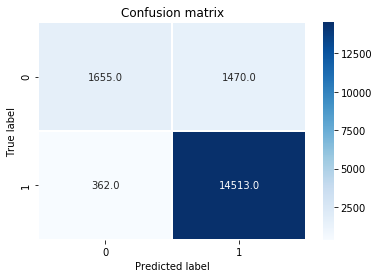

In [30]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_bow)

In [31]:
model_randomlinear.fit(X_trainbow,y_train) 
print(model_randomlinear.best_estimator_)

SGDClassifier(alpha=0.7513405807812017, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [32]:

sgd = SGDClassifier(alpha=0.75)

# fitting the model
sgd.fit(X_trainbow, y_train)

# predict the response
pred_bow=sgd.predict(X_testbow)

acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
acc_train_bow = sgd.score(X_trainbow,y_train)*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))
print("-------------------------------------------------")
print(classification_report(y_test, pred_bow))


The accuracy of the classifier is 89.611111%
accuracy on train data is 93.91904761904762%
error on train data is 6.080952380952382%
error on test data is 10.388888888888886%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.85      0.49      0.62      3125
   positive       0.90      0.98      0.94     14875

avg / total       0.89      0.90      0.88     18000



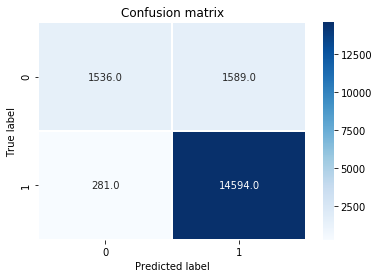

In [33]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_bow)

In [36]:
W = sgd.coef_
W.shape

(1, 24689)

In [37]:
bow_features = count_vec.get_feature_names()

In [38]:
coefs_feat =pd.DataFrame(sorted(zip(sgd.coef_[0], bow_features)))
coefs_feat.shape

(24689, 2)

In [40]:
# To show top 25 feature from both class
# Feature Importance
print("Top 25 Negative Features:-\n",coefs_feat[0:25])
print("\n\n Top 25 Positive Features:-\n",coefs_feat[:-26:-1])

Top 25 Negative Features:-
            0           1
0  -0.063500  disappoint
1  -0.047599      return
2  -0.044993        wast
3  -0.041883     horribl
4  -0.039954          aw
5  -0.038901       worst
6  -0.038261     terribl
7  -0.035294       threw
8  -0.034925       money
9  -0.033800       stale
10 -0.033196    unfortun
11 -0.029895         bad
12 -0.028666      refund
13 -0.028059     disgust
14 -0.025199        poor
15 -0.024845       bewar
16 -0.024433       gross
17 -0.024253       guess
18 -0.023608       sorri
19 -0.023470        yuck
20 -0.022347        mayb
21 -0.021859       didnt
22 -0.021768       throw
23 -0.021518       nasti
24 -0.021470     thought


 Top 25 Positive Features:-
               0          1
24688  0.119068      great
24687  0.115029       love
24686  0.085927       good
24685  0.074147       best
24684  0.063641     delici
24683  0.054203    perfect
24682  0.050270      excel
24681  0.049616    favorit
24680  0.047231       nice
24679  0.041105      

##### Logistic Regression usin GridSearch CV 

In [35]:
from sklearn.decomposition import TruncatedSVD 
from scipy.sparse import csr_matrix

svd = TruncatedSVD(n_components=50)
std_data=svd.fit_transform(X_trainbow)
print("variance preserved",svd.explained_variance_ratio_)
std_data=csr_matrix((std_data))
X_trainden = std_data.todense()

variance preserved [0.03715455 0.0253705  0.01926237 0.01687263 0.01430878 0.01089533
 0.01043966 0.00952542 0.0092354  0.00901842 0.00848251 0.00755202
 0.0075373  0.00696474 0.00620951 0.00610585 0.00593651 0.00572527
 0.00535899 0.00519436 0.00500187 0.00493267 0.00470877 0.00454717
 0.00448908 0.00439848 0.00431503 0.00419318 0.00402719 0.00391545
 0.00369604 0.00361799 0.00350025 0.0034794  0.00339884 0.003283
 0.00324252 0.00322622 0.00312946 0.00311126 0.00303914 0.00300526
 0.00296613 0.00292183 0.00290999 0.00283464 0.00280585 0.00276741
 0.00267453 0.0025925 ]


In [ ]:

model_rbf.fit(X_trainden,y_train) 
print(model_rbf.best_estimator_)

#### Accuracy Report with Best C

In [ ]:

clf = SVC(C=1000,gamma=0.001)

# fitting the model
clf.fit(X_trainbow, y_train)

# predict the response

predicted_labels = []
for i in range(0,7500 , 500):
    predicted_labels.append(clf.predict(X_testbow[i:i+500]))

pred_bow = np.hstack(predicted_labels)
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
for i in range(0,17500 , 500):
    acc_train_bow = clf.score(X_trainbow[i:i+500],y_train[i:i+500])*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))

             precision    recall  f1-score   support

   negative       0.82      0.52      0.64      3125
   positive       0.91      0.98      0.94     14875

avg / total       0.89      0.90      0.89     18000



In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_bow)

array([[ 823,  510],
       [ 183, 5984]])

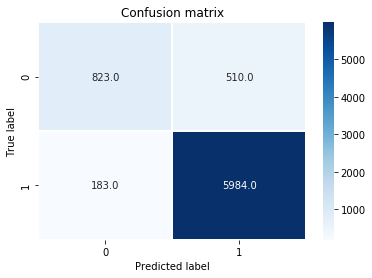

In [0]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_bow)

In [ ]:
clf=SVC(C=1000,gamma=0.001)
C = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
clf.fit(X_trainbow,y_train)
scores=clf.score(X_trainbow,y_train)
# changing to misclassification error
c_scores=[]
c_scores.append(scores.mean())
MSE = [1 - x for x in c_scores]
# plot misclassification error vs k 
plt.plot(C, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('C')
plt.ylabel('Misclassification Error')
plt.show()

In [18]:
score = {'positive': 1,'negative': 0}
y_train = [score[item] for item in y_train] 

In [33]:
#from scipy.sparse import csr_matrix
#std_data=csr_matrix((X_trainbow))
#X_trainden = std_data.todense()

X_trainar=np.array(X_trainbow)
X_trainar.astype(float)
y_trainar=np.array(y_train)


ValueError: setting an array element with a sequence.

In [27]:
X_trainar[0]

IndexError: too many indices for array

In [25]:

from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X=X_trainar, 
                      y=y_trainar,
                      clf=SVC(C=1000,gamma=0.001), 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel(X.columns[0], size=14)
plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=16)

ValueError: X must be an integer or float array. Found object.

##### Logistic Regression usin RandomSearch CV 

In [0]:
model_randomrbf.fit(X_trainbow,y_train)
print(model_randomrbf.best_estimator_)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=15, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1bb7c5a780>, 'gamma': [0.001, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(f1_score, pos_label=negative), verbose=0)

In [0]:
print(model_random.best_estimator_)

SVC(C=2.7371662485446255, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
clf1 = SVC(C=2.74,gamma=0.001)

# fitting the model
clf1.fit(X_trainbow, y_train)

# predict the response

predicted_labels = []
for i in range(0,7500 , 500):
    predicted_labels.append(clf1.predict(X_testbow[i:i+500]))

pred_bow = np.hstack(predicted_labels)
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
for i in range(0,17500 , 500):
    acc_train_bow = clf1.score(X_trainbow[i:i+500],y_train[i:i+500])*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))


The accuracy of the classifier is 82.226667%
accuracy on train data is 85.39999999999999%
error on train data is 14.600000000000009%
error on test data is 17.773333333333326%


#### Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_bow)

array([[   0, 1333],
       [   0, 6167]], dtype=int64)

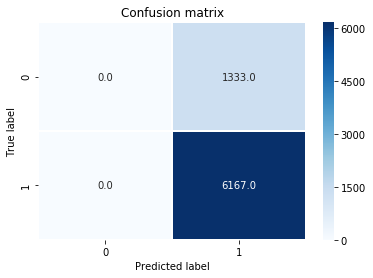

In [0]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_bow)

#### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      2613
   positive       0.83      1.00      0.90     12387

avg / total       0.68      0.83      0.75     15000



#  TF-IDF

In [45]:
from sklearn import preprocessing

tfidf = TfidfVectorizer() #Using bi-grams
X_traintfidf = tfidf.fit_transform(X_train)
print("Train Data Size: ",X_traintfidf.shape)
X_testtfidf = tfidf.transform(X_test)
print("Test Data Size: ",X_testtfidf.shape)

Train Data Size:  (42000, 24689)
Test Data Size:  (18000, 24689)


In [44]:
std_scale = StandardScaler(with_mean = False).fit(X_traintfidf)
X_traintfidf = std_scale.transform(X_traintfidf)
X_testtfidf  = std_scale.transform(X_testtfidf)

##### Logistic Regression usin GridSearch CV 

In [45]:
model_linear.fit(X_traintfidf,y_train)
print(model_linear.best_estimator_)

SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [47]:
sgd = SGDClassifier(alpha=0.5)

# fitting the model
sgd.fit(X_traintfidf, y_train)

# predict the response
pred_tfidf=sgd.predict(X_testtfidf)

acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_tfidf))
acc_train_tfidf = sgd.score(X_traintfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_tfidf))


The accuracy of the classifier is 88.588889%
accuracy on train data is 94.58571428571429%
error on train data is 5.414285714285711%
error on test data is 11.411111111111111%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.78      0.48      0.59      3125
   positive       0.90      0.97      0.93     14875

avg / total       0.88      0.89      0.87     18000



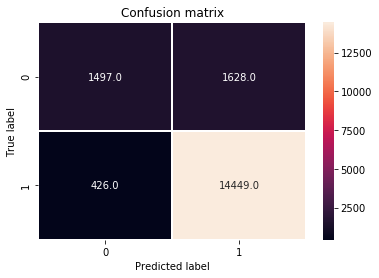

In [48]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_tfidf)

In [49]:
model_randomlinear.fit(X_traintfidf,y_train)
print(model_linear.best_estimator_)

SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [50]:
sgd = SGDClassifier(alpha=0.5)

# fitting the model
sgd.fit(X_traintfidf, y_train)

# predict the response
pred_tfidf=sgd.predict(X_testtfidf)

acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_tfidf))
acc_train_tfidf = sgd.score(X_traintfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_tfidf))


The accuracy of the classifier is 88.527778%
accuracy on train data is 94.56190476190476%
error on train data is 5.438095238095244%
error on test data is 11.472222222222214%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.77      0.48      0.59      3125
   positive       0.90      0.97      0.93     14875

avg / total       0.88      0.89      0.87     18000



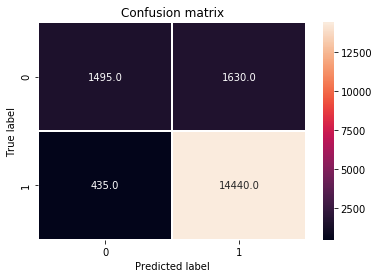

In [51]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_tfidf)

In [52]:
W = sgd.coef_
W.shape

(1, 24689)

In [53]:
tfidf_features = tfidf.get_feature_names()

In [56]:
coefs_feat =pd.DataFrame(sorted(zip(sgd.coef_[0], tfidf_features)))
coefs_feat.shape

(24689, 2)

In [57]:
# To show top 25 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",coefs_feat[0:25])
print("\n\n Top 10 Positive Features:-\n",coefs_feat[:-26:-1])

Top 10 Negative Features:-
            0           1
0  -0.065954  disappoint
1  -0.052985      return
2  -0.046651     horribl
3  -0.046645          aw
4  -0.046624        wast
5  -0.043121       worst
6  -0.042155     terribl
7  -0.035400       threw
8  -0.035230       stale
9  -0.034394      refund
10 -0.032142    unfortun
11 -0.031464         bad
12 -0.029209       money
13 -0.028854     disgust
14 -0.026473       bewar
15 -0.024936       gross
16 -0.024702      cancel
17 -0.024692       sorri
18 -0.024609       nasti
19 -0.024011   tasteless
20 -0.023647        yuck
21 -0.023520        poor
22 -0.023060       guess
23 -0.022665     mislead
24 -0.022483       trash


 Top 10 Positive Features:-
               0        1
24688  0.083897    great
24687  0.082662     love
24686  0.067321     good
24685  0.058940     best
24684  0.051266   delici
24683  0.043118  perfect
24682  0.040985    excel
24681  0.037366     nice
24680  0.034550  favorit
24679  0.033919      use
24678  0.032283 

In [58]:
svd = TruncatedSVD(n_components=50)
std_data1=svd.fit_transform(X_traintfidf)
print("variance preserved",svd.explained_variance_ratio_)
std_data1=csr_matrix((X_traintfidf))
X_trainden1 = std_data1.todense()

variance preserved [0.00221772 0.00177883 0.00127962 0.00015287 0.00092651 0.00089082
 0.00083601 0.00074377 0.00074112 0.0007173  0.00068841 0.00060749
 0.00059246 0.00058216 0.00056528 0.00055448 0.00055385 0.0005291
 0.0005285  0.0005196  0.00050038 0.0004802  0.0004774  0.00047451
 0.00046851 0.00046567 0.00046252 0.00045701 0.00045288 0.00044858
 0.00044231 0.00044124 0.00043825 0.00043321 0.00042728 0.000424
 0.00041891 0.000406   0.00039303 0.00038766 0.00038618 0.00038207
 0.00037759 0.00037441 0.00036978 0.00036819 0.00036378 0.00035767
 0.00034905 0.00034609]


MemoryError: 

In [ ]:
model_rbf.fit(X_trainden1,y_train)
print(model_linear.best_estimator_)

##### Accuracy Report with best C

In [0]:

clf = SVC(C=1000,gamma=0.001)

# fitting the model
clf.fit(X_traintfidf, y_train)

# predict the response

predicted_labels = []
for i in range(0,7500 , 500):
    predicted_labels.append(clf.predict(X_testtfidf[i:i+500]))

pred_tfidf = np.hstack(predicted_labels)
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_tfidf))
for i in range(0,17500 , 500):
    acc_train_tfidf = clf.score(X_traintfidf[i:i+500],y_train[i:i+500])*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))


The accuracy of the classifier is 90.413333%
accuracy on train data is 96.39999999999999%
error on train data is 3.6000000000000085%
error on test data is 9.586666666666659%


##### Logistic Regression usin RandomSearch CV 

In [0]:
model_random.fit(X_traintfidf,y_train)
print(model.best_estimator_)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


##### Accuracy Report with best C

In [0]:

clf1 = SVC(C=1000,gamma=0.001)

# fitting the model
clf1.fit(X_traintfidf, y_train)

# predict the response

predicted_labels = []
for i in range(0,7500 , 500):
    predicted_labels.append(clf1.predict(X_testtfidf[i:i+500]))

pred_tfidf = np.hstack(predicted_labels)
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_tfidf))
for i in range(0,17500 , 500):
    acc_train_tfidf = clf1.score(X_traintfidf[i:i+500],y_train[i:i+500])*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))


The accuracy of the classifier is 90.413333%
accuracy on train data is 96.39999999999999%
error on train data is 3.6000000000000085%
error on test data is 9.586666666666659%


#### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_tfidf)

array([[ 3155,  1993],
       [ 2143, 22709]], dtype=int64)

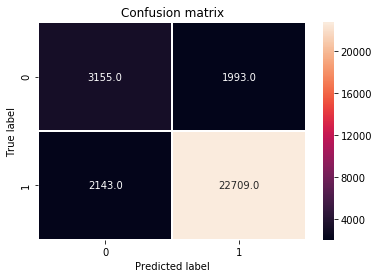

In [0]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_tfidf)

#### Classification Report 

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfidf))

NameError: name 'pred_tfidf' is not defined

# Word TO Vec

In [7]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
# Train your own Word2Vec model using your own train corpus
import gensim
list_of_sent = []
for sent in X_train:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
print(df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

big lover fig jam fig jam uniqu flavor kind mix light kadoda fig dark mission fig must tri
*****************************************************************
['thought', 'grove', 'hot', 'chocol', 'sweet', 'also', 'tast', 'would', 'recommend', 'anybodi']


In [10]:
# min_count = 5 considers only words that occured atleast 5 times

from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [11]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8522
sample words  ['thought', 'grove', 'hot', 'chocol', 'sweet', 'also', 'tast', 'would', 'recommend', 'anybodi', 'great', 'product', 'littl', 'goe', 'long', 'way', 'husband', 'diabet', 'watch', 'carb', 'close', 'use', 'regular', 'granul', 'splenda', 'knew', 'ad', 'lot', 'unnecessari', 'diet', 'ill', 'buy', 'run', 'thank', 'amazon', 'give', 'mani', 'option', 'bread', 'wonder', 'textur', 'sandwich', 'toast', 'make', 'crouton', 'crumb', 'negat', 'larg', 'amount', 'butter']


In [12]:
# Train your own Word2Vec model using your own test corpus
import gensim
list_of_sent_test = []
for sent in X_test:
    filtered_sentence1 = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence1.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence1)

In [13]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

# Avg W2V, TFIDF-W2V

In [15]:
from tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████████████████████████████| 42000/42000 [00:15<00:00, 2718.64it/s]


42000
50


In [16]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████████████████████████████| 18000/18000 [00:06<00:00, 2645.51it/s]


18000
50


In [22]:
X_trainw2v = np.array(sent_vectors)
X_testw2v=np.array(sent_vectors_test)
X_trainw2v=np.nan_to_num(X_trainw2v)
X_testw2v=np.nan_to_num(X_testw2v)

In [23]:
std_scale = StandardScaler(with_mean = False).fit(X_trainw2v)
X_trainw2v = std_scale.transform(X_trainw2v)
X_testw2v  = std_scale.transform(X_testw2v)

##### Logistic Regression usin GridSearch CV 

In [30]:
model_linear.fit(X_trainw2v,y_train)
print(model_linear.best_estimator_)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SGDClassifier(alpha=0.005, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [33]:
sgd = SGDClassifier(alpha=0.005)

# fitting the model
sgd.fit(X_trainw2v, y_train)

# predict the response
pred_w2v=sgd.predict(X_testw2v)

acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2v))
acc_train_w2v = sgd.score(X_trainw2v,y_train)*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))
print("-------------------------------------------------")
print(classification_report(y_test, pred_w2v))


The accuracy of the classifier is 86.144444%
accuracy on train data is 86.18571428571428%
error on train data is 13.814285714285717%
error on test data is 13.855555555555554%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.73      0.32      0.44      3125
   positive       0.87      0.98      0.92     14875

avg / total       0.85      0.86      0.84     18000



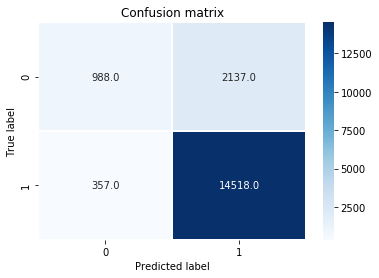

In [34]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2v)

In [35]:
model_randomlinear.fit(X_trainw2v,y_train)
print(model_randomlinear.best_estimator_)

SGDClassifier(alpha=0.09277682708475998, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [36]:
sgd = SGDClassifier(alpha=0.093)

# fitting the model
sgd.fit(X_trainw2v, y_train)

# predict the response
pred_w2v=sgd.predict(X_testw2v)

acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2v))
acc_train_w2v = sgd.score(X_trainw2v,y_train)*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))
print("-------------------------------------------------")
print(classification_report(y_test, pred_w2v))


The accuracy of the classifier is 83.705556%
accuracy on train data is 83.85714285714285%
error on train data is 16.142857142857153%
error on test data is 16.29444444444445%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.83      0.08      0.14      3125
   positive       0.84      1.00      0.91     14875

avg / total       0.84      0.84      0.78     18000



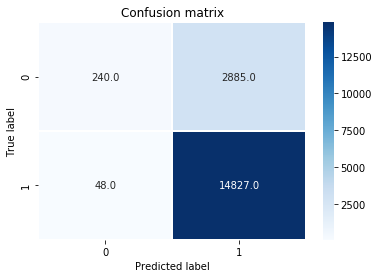

In [37]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2v)

In [42]:
svd = TruncatedSVD(n_components=10)
std_data2=svd.fit_transform(X_trainw2v)
print("variance preserved",svd.explained_variance_ratio_)
std_data2=csr_matrix((X_trainw2v))
X_trainden2 = std_data2.todense()

variance preserved [0.02417816 0.19035812 0.14657396 0.09201056 0.07042017 0.06677584
 0.06375892 0.05121775 0.04561761 0.03729411]


In [ ]:
model_rbf.fit(X_trainden2,y_train)
print(model_rbf.best_estimator_)

#####  AccuracyScore with Best C

In [32]:

clf = SVC(C=1000,gamma=0.01)

# fitting the model
clf.fit(X_trainw2v, y_train)

# predict the response

predicted_labels = []
for i in range(0,7500 , 500):
    predicted_labels.append(clf.predict(X_testw2v[i:i+500]))

pred_w2v = np.hstack(predicted_labels)
acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2v))
for i in range(0,17500 , 500):
    acc_train_w2v = clf.score(X_trainw2v[i:i+500],y_train[i:i+500])*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))


The accuracy of the classifier is 83.720000%
accuracy on train data is 93.2%
error on train data is 6.799999999999997%
error on test data is 16.28%


##### Logistic Regression usin RandomSearch CV 

In [40]:
model_rbf.fit(X_trainden2,y_train)
print(model_rbf.best_estimator_)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=15, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4b9d5e8d0>, 'gamma': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(f1_score, pos_label=negative), verbose=0)

In [41]:
print(model_random.best_estimator_)

SVC(C=2.0180745758943845, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#####  AccuracyScore with Best C

In [42]:

clf1 = SVC(C=1,gamma=0.1)

# fitting the model
clf1.fit(X_trainw2v, y_train)

# predict the response

predicted_labels = []
for i in range(0,7500 , 500):
    predicted_labels.append(clf1.predict(X_testw2v[i:i+500]))

pred_w2v = np.hstack(predicted_labels)
acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2v))
for i in range(0,17500 , 500):
    acc_train_w2v = clf1.score(X_trainw2v[i:i+500],y_train[i:i+500])*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))


The accuracy of the classifier is 84.066667%
accuracy on train data is 89.4%
error on train data is 10.599999999999994%
error on test data is 15.933333333333337%


#### Confusion Matrix

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_w2v)

array([[ 293, 1040],
       [ 155, 6012]])

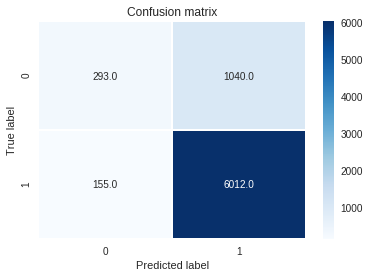

In [44]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2v)

#### Classification Report 

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_w2v))

             precision    recall  f1-score   support

   negative       0.65      0.22      0.33      1333
   positive       0.85      0.97      0.91      6167

avg / total       0.82      0.84      0.81      7500



## TF-IDF weighted Word2Vec

In [43]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
from tqdm import tqdm
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 42000/42000 [01:53<00:00, 369.14it/s]


In [47]:
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 18000/18000 [00:45<00:00, 397.61it/s]


In [48]:

X_trainw2vtfidf=np.array(tfidf_sent_vectors)
X_testw2vtfidf=np.array(tfidf_sent_vectors_test)

In [49]:
X_trainw2vtfidf.shape


(42000, 50)

In [50]:
std_scale = StandardScaler(with_mean = False).fit(X_trainw2vtfidf)
X_trainw2vtfidf = std_scale.transform(X_trainw2vtfidf)
X_testw2vtfidf  = std_scale.transform(X_testw2vtfidf)

In [0]:
X_trainw2vtfidf=X_trainw2vtfidf.ravel()

In [0]:
X_trainw2vtfidf=np.nan_to_num(X_trainw2vtfidf)

##### Logistic Regression usin GridSearch CV 

In [52]:
model_linear.fit(X_trainw2vtfidf,y_train)
print(model_linear.best_estimator_)

SGDClassifier(alpha=0.005, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [53]:
sgd = SGDClassifier(alpha=0.005)

# fitting the model
sgd.fit(X_trainw2vtfidf, y_train)

# predict the response
pred_w2vtfidf=sgd.predict(X_testw2vtfidf)

acc_w2vtfidf = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2vtfidf))
acc_train_w2vtfidf = sgd.score(X_trainw2vtfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_w2vtfidf))
error_train_w2vtfidf = (100-acc_train_w2vtfidf)
print("error on train data is {}%".format(error_train_w2vtfidf))
error_test_w2vtfidf = (100-acc_w2vtfidf)
print("error on test data is {}%".format(error_test_w2vtfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_w2vtfidf))


The accuracy of the classifier is 84.211111%
accuracy on train data is 84.15714285714286%
error on train data is 15.842857142857142%
error on test data is 15.788888888888891%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.76      0.13      0.22      3125
   positive       0.84      0.99      0.91     14875

avg / total       0.83      0.84      0.79     18000



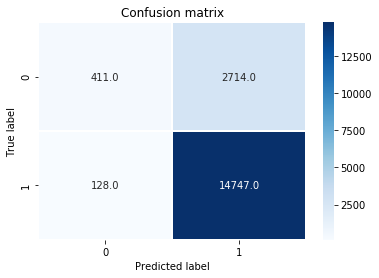

In [54]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2vtfidf)

In [55]:
model_randomlinear.fit(X_trainw2vtfidf,y_train)
print(model_randomlinear.best_estimator_)

SGDClassifier(alpha=0.02241573398966068, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [56]:
sgd = SGDClassifier(alpha=0.022)

# fitting the model
sgd.fit(X_trainw2vtfidf, y_train)

# predict the response
pred_w2vtfidf=sgd.predict(X_testw2vtfidf)

acc_w2vtfidf = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2vtfidf))
acc_train_w2vtfidf = sgd.score(X_trainw2vtfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_w2vtfidf))
error_train_w2vtfidf = (100-acc_train_w2vtfidf)
print("error on train data is {}%".format(error_train_w2vtfidf))
error_test_w2vtfidf = (100-acc_w2vtfidf)
print("error on test data is {}%".format(error_test_w2vtfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_w2vtfidf))


The accuracy of the classifier is 83.055556%
accuracy on train data is 83.22857142857143%
error on train data is 16.771428571428572%
error on test data is 16.944444444444443%
-------------------------------------------------
             precision    recall  f1-score   support

   negative       0.80      0.03      0.06      3125
   positive       0.83      1.00      0.91     14875

avg / total       0.83      0.83      0.76     18000



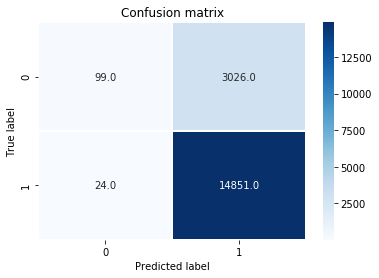

In [57]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2vtfidf)

In [58]:
svd = TruncatedSVD(n_components=10)
std_data3=svd.fit_transform(X_trainw2vtfidf)
print("variance preserved",svd.explained_variance_ratio_)
std_data3=csr_matrix((X_trainw2vtfidf))
X_trainden3 = std_data3.todense()

variance preserved [0.02109509 0.20555713 0.15084606 0.11210046 0.07444917 0.0633069
 0.05629894 0.0456525  0.04008681 0.0356921 ]


In [ ]:
model_rbf.fit(X_trainden3,y_train)
print(model_rbf.best_estimator_)

#####  AccuracyScore with best C

In [0]:

logistic_optimal = LogisticRegression(C=50,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainw2vtfidf, y_train)
# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))

pred_w2vtfidf = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_w2v = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the  classifier for k is %f%%' %(acc_w2v))
for i in range(0,70000 , 1000):
    acc_train_w2v = logistic_optimal.score(X_trainw2vtfidf[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))


The accuracy of the  classifier for k is 87.216667%
accuracy on train data is 87.5%
error on train data is 12.5%
error on test data is 12.783333333333331%


#### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_w2vtfidf)

array([[ 1358,  3032],
       [  804, 24806]], dtype=int64)

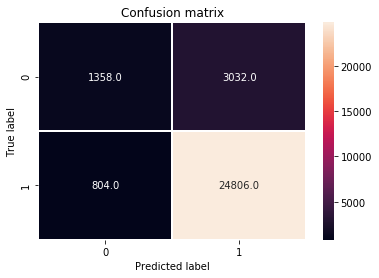

In [0]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2vtfidf)

#### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_w2vtfidf))

             precision    recall  f1-score   support

   negative       0.63      0.31      0.41      4390
   positive       0.89      0.97      0.93     25610

avg / total       0.85      0.87      0.85     30000



##### Logistic Regression usin RandomSearchCV 

In [56]:
model_randomrbf.fit(X_trainden3,y_train)
print(model_randomrbf.best_estimator_)

SVC(C=3.73320614319169, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#####  AccuracyScore with best C

In [0]:

logistic_optimal = LogisticRegression(C=3.336,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainw2vtfidf, y_train)
X_testw2vtfidf=np.nan_to_num(X_testw2vtfidf)
# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))

pred_w2vtfidf = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_w2vtfidf = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the  classifier for k is %f%%' %(acc_w2vtfidf))
for i in range(0,70000 , 1000):
    acc_train_w2vtfidf = logistic_optimal.score(X_trainw2vtfidf[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_w2vtfidf))
error_train_w2vtfidf = (100-acc_train_w2vtfidf)
print("error on train data is {}%".format(error_train_w2vtfidf))
error_test_w2vtfidf = (100-acc_w2vtfidf)
print("error on test data is {}%".format(error_test_w2vtfidf))


The accuracy of the  classifier for k is 87.213333%
accuracy on train data is 87.6%
error on train data is 12.400000000000006%
error on test data is 12.786666666666662%


#### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_w2vtfidf)

array([[ 1352,  3038],
       [  797, 24813]], dtype=int64)

#### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_w2vtfidf))

             precision    recall  f1-score   support

   negative       0.63      0.31      0.41      4390
   positive       0.89      0.97      0.93     25610

avg / total       0.85      0.87      0.85     30000



In [0]:
logistic_optimal.fit(X_trainw2vtfidf_n,y_train)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Conclusion
1)AVG W2V Featurization performs best with accuracy of 93.704 and F1-Score of 0.808
2)Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used
3)Logistic Regression performed best on this data

## Performance Table

In [0]:
x = PrettyTable()

x.field_names = ["Featurization", "CV","C", "Penalty","Accuracy","F1 Score"]

x.add_row(["BOW","GridSearch", 1,"L2" ,86.82,0.87])
x.add_row(["BOW","RandomSearch",1,"L2",86.82,0.87])
x.add_row(["TFIDF","GridSearch", 5,"L2" ,86.82,0.86])
x.add_row(["TFIDF","RandomSearch",5,"L2",86.82,0.86])
x.add_row(["AVG W2V","GridSearch", 50,"L2" ,87.98,0.87])
x.add_row(["AVG W2V","RandomSearch",1,"L2",87.89,0.86])
x.add_row(["TFIDF W2V","GridSearch", 50,"L2" ,87.21,0.85])
x.add_row(["TFIDF W2V","RandomSearch",3.336,"L2",87.21,0.85])

print(x)


+---------------+--------------+-------+---------+----------+----------+
| Featurization |      CV      |   C   | Penalty | Accuracy | F1 Score |
+---------------+--------------+-------+---------+----------+----------+
|      BOW      |  GridSearch  |   1   |    L2   |  86.82   |   0.87   |
|      BOW      | RandomSearch |   1   |    L2   |  86.82   |   0.87   |
|     TFIDF     |  GridSearch  |   5   |    L2   |  86.82   |   0.86   |
|     TFIDF     | RandomSearch |   5   |    L2   |  86.82   |   0.86   |
|    AVG W2V    |  GridSearch  |   50  |    L2   |  87.98   |   0.87   |
|    AVG W2V    | RandomSearch |   1   |    L2   |  87.89   |   0.86   |
|   TFIDF W2V   |  GridSearch  |   50  |    L2   |  87.21   |   0.85   |
|   TFIDF W2V   | RandomSearch | 3.336 |    L2   |  87.21   |   0.85   |
+---------------+--------------+-------+---------+----------+----------+
